In [1]:
import genjax
import jax.numpy as jnp
from genjax import gen, categorical
from genjax import ChoiceMap as Chm
import jax.random as jrand
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams['text.usetex'] = True
sns.set_theme(style="white")

In [2]:
@gen
def model(θ): # θ in \mathbb{R}^K
    new_θ = θ
    permutation = []
    for _iter in range(jnp.shape(θ)[0]):
        new_θ = new_θ / jnp.sum(new_θ)
        idx = categorical(probs=new_θ) @ f"idx_{_iter}"
        new_θ = new_θ.at[idx].set(1e-9)
        permutation.append(idx)
    return jnp.array(permutation)

tr = model.simulate(jrand.key(1), (jnp.ones(5), ))

In [3]:
permutation = tr.get_retval()
chm = Chm.d({f"idx_{idx}": v for (idx, v) in enumerate(permutation)})
chm

Static({
  'idx_4': Choice(v=<jax.Array(3, dtype=int32)>),
  'idx_1': Choice(v=<jax.Array(2, dtype=int32)>),
  'idx_3': Choice(v=<jax.Array(0, dtype=int32)>),
  'idx_0': Choice(v=<jax.Array(4, dtype=int32)>),
  'idx_2': Choice(v=<jax.Array(1, dtype=int32)>),
})

In [4]:
model.assess(chm, (jnp.ones(5), ))

(Array(-4.787492, dtype=float32), Array([4, 2, 1, 0, 3], dtype=int32))

## REINFORCE

Assume $R(x) = 1$, for all x.
Implies that $\mathbb{E}_{x \sim P(\cdot; \theta)}[R(x)] = 1$, so $\nabla_\theta~\{...\} = 0$.

If we use REINFORCE as an estimator for the above, the following happens:
$$\mathbb{E}_{x \sim P(\cdot; \theta)}[\nabla_\theta \log P(x; \theta)]$$

Straightforwardly, the more random variates we add:
$$\mathbb{E}_{(r, x) \sim P(\cdot; \theta)}[\nabla_\theta \log P(r, x; \theta)]$$

Supposing $P(r, x; \theta) = P(r; \theta)P(x; \theta)$:
$$
\begin{align}
&\mathbb{E}_{(r, x) \sim P(\cdot; \theta)}[\nabla_\theta \log P(r; \theta) + \nabla_\theta \log P(x; \theta)] = \\ &\mathbb{E}_{r \sim P(\cdot; \theta)}[\nabla_\theta \log P(r; \theta)] + \mathbb{E}_{x \sim P(\cdot; \theta)}[\nabla_\theta \log P(x; \theta)]
\end{align}
$$

and it's straightforward to see that we're increasing the variance of an estimator of the true value ($0$).

The same observation holds if the reward $R(x)$ does not depend on $r$.

In [5]:
def reinforce(key, θ):
    permutation = model.simulate(key, (θ, )).get_retval()
    chm = Chm.d({f"idx_{idx}": v for (idx, v) in enumerate(permutation)})
    return grad(lambda θ: model.assess(chm, (θ, ))[0])(θ)

In [6]:
vreinforce = jit(vmap(reinforce, in_axes=(0, None)))

def est_for_k(key, k, n, random=False):
    key, sub_key = jrand.split(key)
    θ_ests = vreinforce(
        jrand.split(key, n),
        jrand.uniform(sub_key, shape=k) if random else jnp.ones(k, dtype=float)
    )
    return jnp.linalg.norm(jnp.cov(θ_ests, rowvar=False), ord=2)

In [7]:
xrange = range(2, 30)
points = [est_for_k(jrand.key(5), k, 5000) for k in xrange]

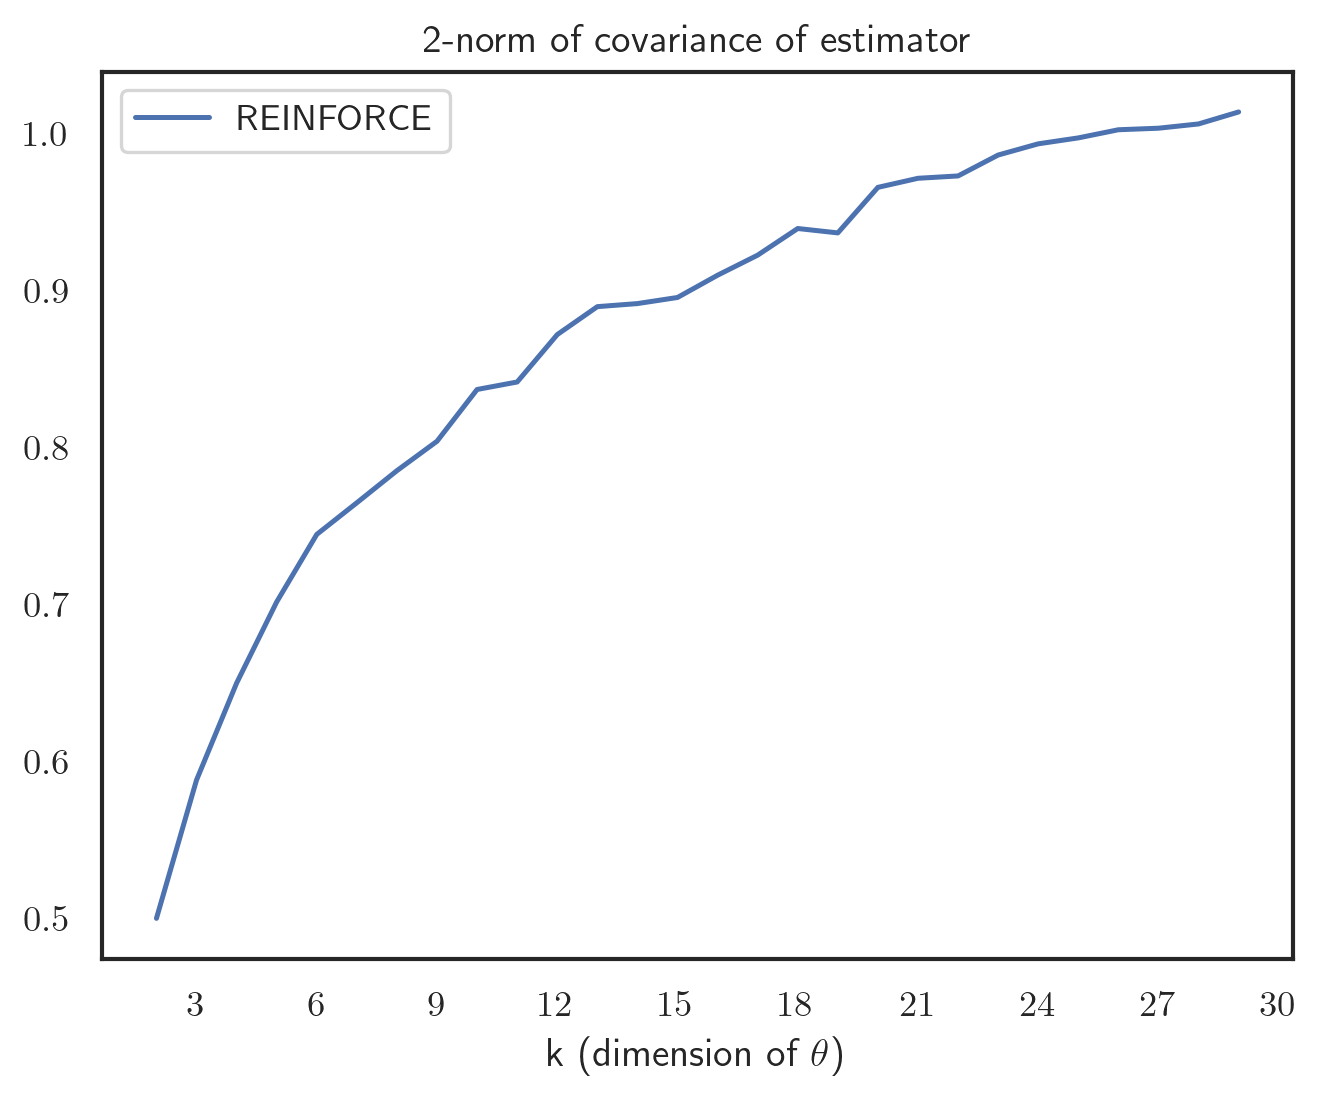

In [10]:
fig, ax = plt.subplots(dpi=240)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(xrange, points, label="REINFORCE")
ax.set_title("2-norm of covariance of estimator")
plt.legend()
plt.xlabel(r"k (dimension of $\theta$)");
plt.savefig("reinforce_2_30_5000.pdf", format="pdf")